<a href="https://colab.research.google.com/github/vicky1412/Predicting_stocks_using_deep_learning-using-realtime-/blob/main/real_time_1m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install alpha_vantage

## Imports

In [ ]:
import datetime
import time
import math
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.models import load_model
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Load the model

In [ ]:
modelnew = load_model('/content/drive/MyDrive/Option Trading/model-1m(price).h5')
modelold = load_model('/content/drive/MyDrive/Option Trading/options-5m-model.h5')

## Create API object

In [ ]:
from alpha_vantage.foreignexchange import ForeignExchange

API_Key = 'GICCCRW4PJWT0C9'
ts = ForeignExchange(key=API_Key,output_format='pandas')


## Real-time prediction

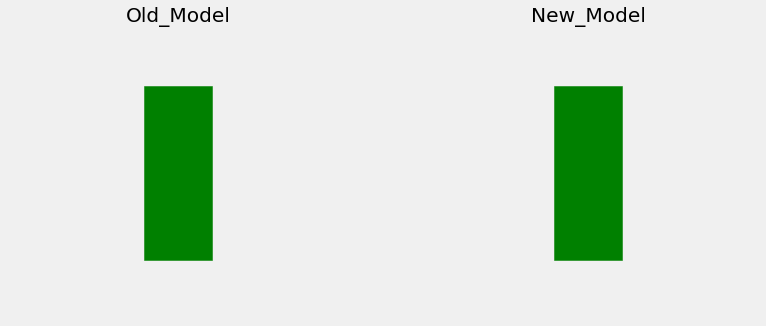

In [ ]:
data = ts.get_currency_exchange_intraday(from_symbol='EUR', to_symbol='USD', interval='1min', outputsize='full')[0]
# Rename the columns
data.rename(columns = {'1. open':'Open'}, inplace = True)
data.rename(columns = {'2. high':'High'}, inplace = True)
data.rename(columns = {'3. low':'Low'}, inplace = True)
data.rename(columns = {'4. close':'Close'}, inplace = True)
# set Index
data['Index'] = np.arange(len(data))
data.set_index('Index',inplace=True)
# Add Candle column
def colors(row):
  if row['Open'] < row['Close']:
    return 1
  elif row['Open'] > row['Close']:
    return 0
  else:
    return 0
data['Candle'] = data.apply (lambda row: colors(row), axis=1)
# Target (Close) and (Candle)
dfclose = data.filter(['Close'])
dfcandle = data.filter(['Candle'])
# extract last 60 
# reverse it
last_60_1m_close = dfclose[0:60]
last_60_1m_close = last_60_1m_close.iloc[::-1]
# set Index
last_60_1m_close['Index'] = np.arange(len(last_60_1m_close))
last_60_1m_close.set_index('Index',inplace=True)

def predictprice(price_data):
  # DF-->array
  price_data = price_data.values
  # Scale(0,1)
  scaler = MinMaxScaler(feature_range=(0,1))
  last_60_1m_price_scaled = scaler.fit_transform(price_data)
  objprice = scaler.fit(price_data)
  #create x_test
  x_test_price = []
  x_test_price.append(last_60_1m_price_scaled)
  # X_test-->numpy array
  x_test_price = np.array(x_test_price)
  # Reshape
  x_test_price = np.reshape(x_test_price,(x_test_price.shape[0],x_test_price.shape[1],1))
  #Predict
  predict_price_new = modelnew.predict(x_test_price)
  predict_price_new = objprice.inverse_transform(predict_price_new)
  predict_price_old = modelold.predict(x_test_price)
  predict_price_old = objprice.inverse_transform(predict_price_old)
  return predict_price_old,predict_price_new

# Predict
predict_price_old,predict_price_new = predictprice(last_60_1m_close)

# Get data for plotting
# previous value
# extract last 10 
previous_candle = dfcandle[0:10]
# reverse it
previous_candle = previous_candle.iloc[::-1]
# set Index
previous_candle['Index'] = np.arange(len(previous_candle))
previous_candle.set_index('Index',inplace=True)
# predited value
# predict_old
if data.Close[0] < predict_price_old[0][0]:
  predict_old = 1
elif data.Close[0] > predict_price_old[0][0]:
  predict_old = 0
else:
  predict_old = 0
# predict_new
if data.Close[0] < predict_price_new[0][0]:
  predict_new = 1
elif data.Close[0] > predict_price_new[0][0]:
  predict_new = 0
else:
  predict_new = 0

# Virtualize
fig, ax = plt.subplots(1,2,figsize=(12,5))
# Title
ax[0].set(title="Old_Model", xlabel="Height", ylabel="Width")
ax[1].set(title="New_Model", xlabel="Height", ylabel="Width")
# X and Y limit
ax[0].set_xlim(0,5)
ax[0].set_ylim(0,5)
ax[1].set_xlim(0,5)
ax[1].set_ylim(0,5)
# hide grid
ax[0].grid(False)
ax[1].grid(False)
# hide axis
ax[0].axis('off')
ax[1].axis('off')

def rects(axx,ayy,width,height,cancolor):
  rect = matplotlib.patches.Rectangle((axx, ayy),width, height,color =cancolor)
  return rect

# Previous candles
# ayy = 0
# for index, row in previous_candle.iterrows():
#   axx = index*1
#   if row["Candle"] == 1:
#     ayy = ayy + 3
#     cancolor = 'Green'
#     rect = rects(axx,ayy,1,3,cancolor)
#     ax[0].add_patch(rect)
#   elif row["Candle"] == 0:
#     ayy = ayy - 3
#     cancolor = 'Red'
#     rect = rects(axx,ayy,1,3,cancolor)
#     ax[0].add_patch(rect)

# Predicted candle
# predicted_old
if predict_old == 1:
  rect = rects(2,1,1,3,'green')
  ax[0].add_patch(rect)
else:
  rect = rects(2,1,1,3,'red')
  ax[0].add_patch(rect)
# predicted_new
if predict_new == 1:
  rect = rects(2,1,1,3,'green')
  ax[1].add_patch(rect)
else:
  rect = rects(2,1,1,3,'red')
  ax[1].add_patch(rect)


## Data

In [ ]:
data = ts.get_currency_exchange_intraday(from_symbol='EUR', to_symbol='USD', interval='1min', outputsize='full')[0]
data.head()

## Data Manipulation

In [ ]:
# Rename the columns
data.rename(columns = {'1. open':'Open'}, inplace = True)
data.rename(columns = {'2. high':'High'}, inplace = True)
data.rename(columns = {'3. low':'Low'}, inplace = True)
data.rename(columns = {'4. close':'Close'}, inplace = True)

In [ ]:
# set Index
data['Index'] = np.arange(len(data))
data.set_index('Index',inplace=True)

In [ ]:
# Add Candle column

def colors(row):
  if row['Open'] < row['Close']:
    return 1
  elif row['Open'] > row['Close']:
    return 0
  else:
    return 0
    
data['Candle'] = data.apply (lambda row: colors(row), axis=1)

In [ ]:
# Target (Close) and (Candle)
dfclose = data.filter(['Close'])
dfcandle = data.filter(['Candle'])


In [ ]:
data

## Extract last 60 data

In [ ]:
# extract last 60 
# reverse it
last_60_1m_close = dfclose[0:60]
last_60_1m_close = last_60_1m_close.iloc[::-1]

# set Index
last_60_1m_close['Index'] = np.arange(len(last_60_1m_close))
last_60_1m_close.set_index('Index',inplace=True)

60

## Predict function

In [ ]:
def predictprice(price_data):
  # DF-->array
  price_data = price_data.values

  # Scale(0,1)
  scaler = MinMaxScaler(feature_range=(0,1))
  last_60_1m_price_scaled = scaler.fit_transform(price_data)

  objprice = scaler.fit(price_data)

  #create x_test
  x_test_price = []
  x_test_price.append(last_60_1m_price_scaled)

  # X_test-->numpy array
  x_test_price = np.array(x_test_price)

  # Reshape
  x_test_price = np.reshape(x_test_price,(x_test_price.shape[0],x_test_price.shape[1],1))

  #Predict
  predict_price = modelprice.predict(x_test_price)
  predict_price = objprice.inverse_transform(predict_price)

  return predict_price


In [ ]:
predict_price = predictprice(last_60_1m_close)

## Get Data for Plotting

In [ ]:
# previous value

# extract last 10 
# reverse it
previous_candle = dfcandle[0:10]
previous_candle = previous_candle.iloc[::-1]
# set Index
previous_candle['Index'] = np.arange(len(previous_candle))
previous_candle.set_index('Index',inplace=True)

# predited value

if data.Close[0] < predict_price[0][0]:
  predict = 1
elif data.Close[0] > predict_price[0][0]:
  predict = 0
else:
  predict = 0


## Virtualize

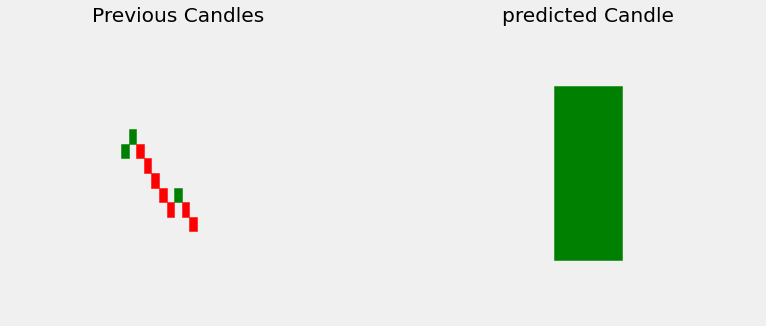

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].set(title="Previous Candles", xlabel="Height", ylabel="Width")
ax[1].set(title="predicted Candle", xlabel="Height", ylabel="Width")

ax[0].set_xlim(-15,30)
ax[0].set_ylim(-30,30)
ax[1].set_xlim(0,5)
ax[1].set_ylim(0,5)

# hide grid
ax[0].grid(False)
ax[1].grid(False)

# hide axis
ax[0].axis('off')
ax[1].axis('off')

def rects(axx,ayy,width,height,cancolor):
  rect = matplotlib.patches.Rectangle((axx, ayy),width, height,color =cancolor)
  return rect

# Previous candles

ayy = 0
for index, row in previous_candle.iterrows():
  axx = index*1
  if row["Candle"] == 1:
    ayy = ayy + 3
    cancolor = 'Green'
    rect = rects(axx,ayy,1,3,cancolor)
    ax[0].add_patch(rect)
  elif row["Candle"] == 0:
    ayy = ayy - 3
    cancolor = 'Red'
    rect = rects(axx,ayy,1,3,cancolor)
    ax[0].add_patch(rect)

# Predicted candle

if predict == 1:
  rect = rects(2,1,1,3,'green')
  ax[1].add_patch(rect)
else:
  rect = rects(2,1,1,3,'red')
  ax[1].add_patch(rect)